# Dialanine Monte Carlo

In this tutorial, we will explore the Ramachandran plot of the dialanine peptide using Metropolis Monte Carlo sampling, entirely within the MolSysMT environment.

We'll walk through the following steps:

- Construct a capped dialanine peptide in vacuum.
- Interact with its backbone dihedral angles: φ (*phi*) and ψ (*psi*).
- Perform Metropolis Monte Carlo sampling over these dihedrals.
- Visualize the resulting Ramachandran distribution.

Before starting the workflow, let’s import the Python libraries required for this notebook.

In [1]:
import numpy as np
import seaborn as sns
import molsysmt as msm
from molsysmt import pyunitwizard as puw

## Build the Dialanine Peptide

We begin by constructing a dipeptide of alanine using the `molsysmt.build.build_peptide()` function.  
To ensure the molecule remains neutral in charge, we cap it with an acetyl group (Ace) at the N-terminus and an N-methylamide group (Nme) at the C-terminus.

In [2]:
dialanine = msm.build.build_peptide('AceAlaNme')

The molecule can be visualized using the **NGLView** Python library.

In [4]:
msm.view(dialanine, viewer='NGLView')

NGLWidget()

## Playing with Phi and Psi

Before running the Metropolis Monte Carlo simulation, let’s first explore some of the MolSysMT methods for extracting and modifying dihedral angles.

The function `molsysmt.structure.get_dihedral_angles()` retrieves backbone torsion angles.  
In this case, we are interested in the values of $\phi$ (phi) and $\psi$ (psi), which describe the conformation of the peptide backbone:

- $\phi$ (phi): the dihedral angle defined by the atoms $C–N–C_{α}–C$
- $\psi$ (psi): the dihedral angle defined by the atoms $N–C_{α}–C–N$


In [5]:
phis, psis = msm.structure.get_dihedral_angles(dialanine, phi=True, psi=True)

In [8]:
phis[0] # There is only a single structure with a list of a single phi value

Magnitude,[-179.9997761712254]
Units,degree


In [9]:
psis[0]

Magnitude,[179.99992099940596]
Units,degree


We can also retrieve the atom quartets (lists of four atom indices) involved in the definition of each dihedral angle.

In [10]:
quartets_phi = msm.topology.get_dihedral_quartets(dialanine, phi=True)

In [11]:
quartets_psi = msm.topology.get_dihedral_quartets(dialanine, psi=True)

In [12]:
quartets_phi

[[4, 6, 8, 14]]

In [13]:
quartets_psi

[[6, 8, 14, 16]]

The values of the dihedral angles can be modified using the `molsysmt.structure.shift_dihedral_angles()` method.  
Let’s illustrate how this is done in the following cell:

In [15]:
msm.structure.shift_dihedral_angles(dialanine, dihedral_quartets=[quartets_phi[0], quartets_psi[0]],
                                    shifts=['10 degrees', '-20 degrees'], in_place=True)

Let’s verify that the dihedral angles have been correctly updated after the shift:

In [16]:
phi, psi = msm.structure.get_dihedral_angles(dialanine, phi=True, psi=True)

In [17]:
phi

Magnitude,[[-169.99977617280967]]
Units,degree


In [18]:
psi

Magnitude,[[159.99992100450456]]
Units,degree


## Getting the Potential Energy

At this point, we have our molecular system ready, and we’ve seen how to retrieve and modify its backbone dihedral angles ($\phi$, $\psi$).  
To complete the setup for a Metropolis Monte Carlo sampling workflow, we also need to compute the potential energy of the dipeptide in vacuum.

This can be done using the function {func}`molsysmt.molecular_mechanics.get_potential_energy`.

In [19]:
msm.molecular_mechanics.get_potential_energy(dialanine)

<Quantity(-72.5291944, 'kilojoule / mole')>

## Metropolis Monte Carlo

We now have all the building blocks to implement a Metropolis Monte Carlo sampling routine for our dialanine system.

Next, we’ll define the temperature, the number of Monte Carlo steps, and the **Boltzmann constant**, which are required to evaluate the acceptance criterion for each Monte Carlo move:


$$
P = 
\begin{cases}
1, & \text{if } \Delta E \leq 0 \\\\
\exp\left( -\dfrac{\Delta E}{k_B T} \right), & \text{if } \Delta E > 0
\end{cases}
$$

Where:
- $\Delta E = E_{\text{after}} - E_{\text{before}}$ is the change in potential energy.
- $k_B$ is the Boltzmann constant.
- $T$ is the absolute temperature in Kelvin.

In [27]:
temperature = puw.quantity(900.0, 'kelvin')
kB = puw.quantity('0.00813446261815324 kilojoules/(kelvin*mole)')

Now, let’s define the Monte Carlo move. Each dihedral angle will be randomly shifted within the interval [ $-20^\circ$, $20^\circ$),  
using a uniform probability distribution.

In [31]:
max_step = puw.quantity(40.0, 'degrees')
random_shifts = np.random.uniform(-1, 1, size=2) * max_step

print(random_shifts)

[-25.960410871161823 -13.715678261304793] degree


We can now run the Metropolis Monte Carlo simulation, keeping track of the visited dihedral angles and the acceptance ratio.

In [50]:
mc_steps = 100
ramachandran_exploration = []

In [51]:
E_before = msm.molecular_mechanics.get_potential_energy(dialanine)
angles = msm.structure.get_dihedral_angles(dialanine, dihedral_quartets=[quartets_phi[0], quartets_psi[0]])

n_accepted = 0

for _ in range(mc_steps):
    
    random_shifts = np.random.uniform(-1, 1, size=2) * max_step
    dialanine_after = msm.structure.shift_dihedral_angles(dialanine, dihedral_quartets=[quartets_phi[0], quartets_psi[0]],
                                                          shifts=random_shifts)
    E_after = msm.molecular_mechanics.get_potential_energy(dialanine_after)
    
    delta_E = E_after - E_before

    if delta_E <= 0:
        accept = True
    else:
        prob = np.exp(-delta_E / (kB * temperature))
        accept = np.random.rand() < prob

    if accept:
        n_accepted += 1
        dialanine = dialanine_after
        E_before = E_after
        angles = msm.structure.get_dihedral_angles(dialanine, dihedral_quartets=[quartets_phi[0], quartets_psi[0]])

    ramachandran_exploration.append(angles[0])

Let’s take a look at the acceptance ratio from our Monte Carlo exploration:

In [52]:
n_accepted/mc_steps

0.6

And here are the first 5 ($\phi$, $\psi$) angle pairs recorded during the simulation:

In [53]:
ramachandran_exploration[:5]

[<Quantity([-81.71641341  93.83109432], 'degree')>,
 <Quantity([-81.71641341  93.83109432], 'degree')>,
 <Quantity([-81.71641341  93.83109432], 'degree')>,
 <Quantity([-81.59129564 112.50126769], 'degree')>,
 <Quantity([-73.19328388 106.79423291], 'degree')>]

### Resulting Ramachandran Plot

The list of collected dihedral angle pairs ($\phi$, $\psi$) can be used to generate a density map over the Ramachandran plot.  
For this, we’ll use the Seaborn Python library to create a smooth and visually informative representation of the sampled conformational space.

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

But first, we need to convert the `ramachandran_exploration` list into a NumPy `ndarray` with shape (mc_steps, 2).  
We'll also strip out the units (degrees) from the quantity to work directly with the raw numerical values:

In [55]:
ramachandran_exploration = puw.utils.numpy.vstack(ramachandran_exploration)
ramachandran_exploration = puw.get_value(ramachandran_exploration)

Finally, here it is the resulting Ramachandran plot:

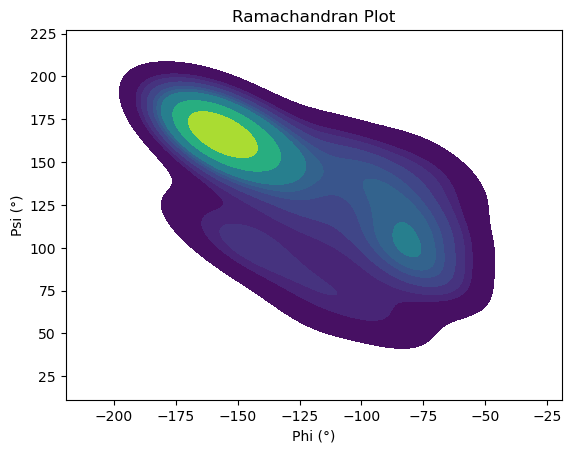

In [56]:
ax = sns.kdeplot(
    x=ramachandran_exploration[:, 0], 
    y=ramachandran_exploration[:, 1], 
    fill=True, cmap='viridis', 
    thresh=0.05, levels=10
)

# Etiquetas y título (ajústalas según tu caso)
ax.set_xlabel('Phi (°)')
ax.set_ylabel('Psi (°)')
ax.set_title('Ramachandran Plot')

plt.show()